# Self Pulsing in Silicon Microring Resonator

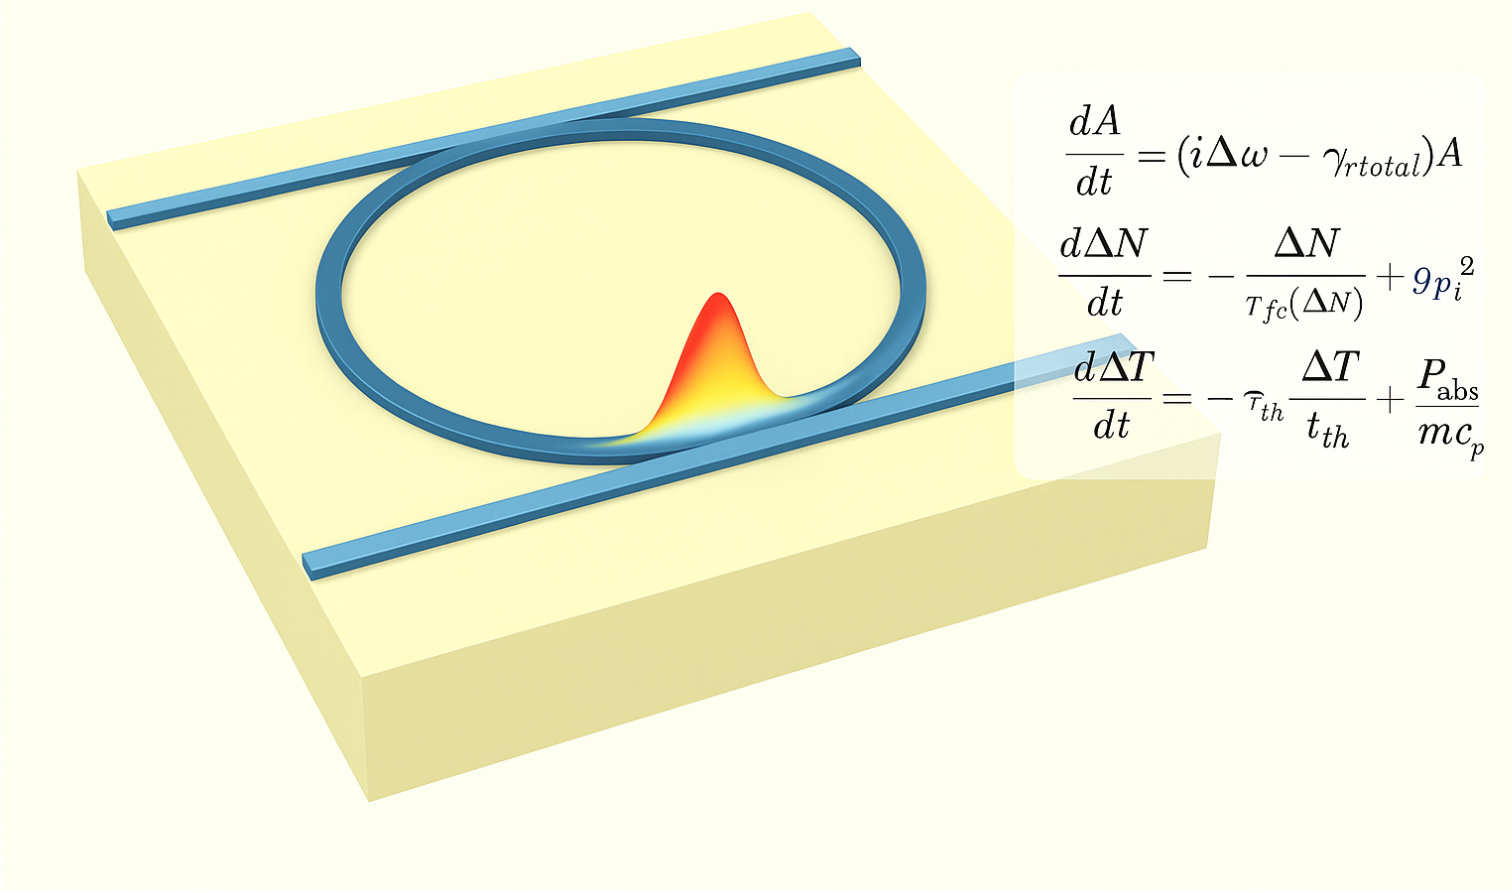

This notebook demonstrates how to build a custom **time-domain model** in PhotonForge by implementing the dynamics of a nonlinear silicon microring resonator.  

Microrings are compact resonant structures that confine light and are sensitive to **carrier effects** and **thermal nonlinearities**. These interactions can give rise to rich temporal behaviors such as **self-pulsing** and **transient oscillations** [1], making them an excellent example for showcasing custom modeling.  

While PhotonForge provides many built-in models, there are situations where you may want to implement your own physics. This could be:
- to capture **nonlinear effects** not included in the standard models,  
- to reproduce equations directly from a reference paper, or  
- to test new ideas at the **circuit level**, where the microring interacts with other components.  

By the end of this notebook, you will see how the **coupled-mode equations** for a microring can be directly coded into a `TimeStepper` model in PhotonForge. This approach is general: once you learn the workflow, you can extend it to any device or physics you want, making PhotonForge a flexible environment for both **research** and **design exploration**.  


**References**
1. Borghi, Massimo, *et al*. "On the modeling of thermal and free carrier nonlinearities in silicon-on-insulator microring resonators." *Optics Express* 29 (3), 4363–4377 (2021). doi: [10.1364/OE.413572](https://doi.org/10.1364/OE.413572).


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
from scipy.integrate import solve_ivp

pf.config.default_technology = pf.basic_technology()

## Parameters 

We declare **all constants and device parameters first** so the rest of the notebook can import them without hunting. Swap these numbers for your process/device; the equations and models in later cells will *only* reference these names.

> Conventions: `|A|^2 = U` (stored energy), per-bus coupling uses `sqrt(2*gamma_e)`, heating uses `P_abs = gamma_abs * U` with `gamma_abs = 2*(gamma_i + eta_fca*ΔN + eta_tpa*U)`.


In [2]:
# === FUNDAMENTAL CONSTANTS ===
c = 299_792_458  # Speed of light [m/s]
h_bar = 1.054_571_817e-34  # Reduced Planck constant [J·s]

# === RESONATOR PARAMETERS ===
omega0 = 2 * np.pi * 192.88e12  # Resonance angular frequency [rad/s]
f0 = 192.88e12  # Resonance frequency [Hz]
lambda0 = c / f0  # Resonance wavelength [m]

# Coupling / loss (per bus extrinsic; intrinsic)
gamma_e = 43e9  # Extrinsic coupling loss rate [s^-1]
gamma_i = 5.5e9  # Intrinsic loss rate [s^-1]

# === MATERIAL PROPERTIES ===
n_si = 3.485  # Linear refractive index
n_g = 4.4  # Group index
dn_dT = 1.86e-4  # Thermo-optic coefficient [K^-1]

# Free-carrier dispersion (lumped form + per-species if needed)
sigma_fcd = -9.5e-27  # Lumped FCD coefficient [m^3]
sigma_fcd_1 = -1.07e-27  # Electron FCD coefficient [m^3]
sigma_fcd_2 = -1.63e-22  # Hole FCD coefficient [m^3]^0.8

# Free-carrier absorption
sigma_fca = 1.5e-21  # FCA cross-section [m^2]

# Two-photon absorption
beta_tpa = 8.1e-12  # TPA coefficient [m/W]

# === CONFINEMENT FACTORS ===
gamma_fc = 0.999  # Free-carrier optical-mode confinement (Γ_FC)
Gamma_tpa = 0.992  # TPA optical-mode confinement (Γ_TPA)

# === EFFECTIVE VOLUMES ===
v_fca = 4.87e-18  # Effective volume for FCA [m^3]
v_tpa = 5.35e-18  # Effective volume for TPA [m^3]

# === THERMAL PROPERTIES ===
m = 1.09e-14  # Physical mass of microring [kg]
c_p = 700.0  # Specific heat capacity of silicon [J·kg^-1·K^-1]

# === TIME CONSTANTS ===
tau_th = 275e-9  # Thermal relaxation time [s]

# === Derived parameters ===
# Free-carrier generation rate per intracavity energy due to TPA [s^-1/J]
g_tpa = (gamma_fc * c**2 * beta_tpa) / (2 * n_si**2 * h_bar * omega0 * v_fca**2)

# TPA loss rate per intracavity energy [s^-1/J]
eta_tpa = (Gamma_tpa * c**2 * beta_tpa) / (2 * n_si**2 * v_tpa)

# FCA loss rate per carrier density [m^3·s^-1]
eta_fca = (c * sigma_fca) / n_g

# --- quick sanity printout ---
print(f"λ0 = {lambda0*1e9:.2f} nm")
print(f"Q_e (per bus) ≈ {omega0/(2*gamma_e):.2e},  Q_i ≈ {omega0/(2*gamma_i):.2e}")
print(
    f"eta_fca = {eta_fca:.2e} m^3/s,  eta_tpa = {eta_tpa:.2e} s^-1/J,  g_tpa = {g_tpa:.2e} s^-1/J"
)

λ0 = 1554.30 nm
Q_e (per bus) ≈ 1.41e+04,  Q_i ≈ 1.10e+05
eta_fca = 1.02e-13 m^3/s,  eta_tpa = 5.56e+21 s^-1/J,  g_tpa = 9.88e+57 s^-1/J


### SRH free-carrier lifetime

We define the Shockley–Read–Hall (SRH) lifetime used in the carrier ODE. All densities are in **m⁻³** (we convert once from cm⁻³), and times are in **seconds**.


In [3]:
# --- Unit conversion ---
cm3_to_m3 = 1e6

# Trap parameters (seconds)
tau_p = 35e-9  # s  (hole lifetime)
tau_n = 22.5e-9  # s  (electron lifetime)

# Doping / intrinsic densities (now converted to m^-3)
ni = 5e11 * cm3_to_m3
p0 = 1e15 * cm3_to_m3

# Energetics & temperature
Ei, Et = 0.56, 0.66  # eV
T = 293.15  # K
kb_eV = 8.617333262e-5  # eV/K

# --- Equilibrium densities (m^-3) ---
n0 = (ni**2) / p0
n1 = ni * np.exp((Et - Ei) / (kb_eV * T))
p1 = ni * np.exp(-(Et - Ei) / (kb_eV * T))

# --- SRH lifetime parameters (SI units) ---
a = (tau_p + tau_n) / (tau_p * (n1 + n0) + tau_n * (p1 + p0))
b = 1.0 / (n0 + p0)
tau0 = tau_p * (n0 + n1) / (n0 + p0) + tau_n * (p0 + p1) / (n0 + p0)


def tau_fc_of_N(DeltaN_m3):
    """
    SRH effective lifetime τ_fc(ΔN) in seconds.
    DeltaN_m3: carrier density deviation (m^-3); works with scalars or numpy arrays.
    """
    return tau0 * (1.0 + a * DeltaN_m3) / (1.0 + b * DeltaN_m3)

## Coupled-Mode Formulation

We model the time-domain dynamics of a symmetric double-bus microring using coupled-mode theory, capturing the interaction between the intracavity optical field, free carriers, and temperature.

### State Variables
- **A(t)**: Complex intracavity field amplitude (normalized so $U = |A|^2$ is stored energy).  
- **ΔN(t)**: Free-carrier density change from equilibrium.  
- **ΔT(t)**: Temperature change from equilibrium.

### Key Relations
- **Intracavity energy:**  
  $$ U = |A|^2 $$
- **Detuning:**  
  $$ \delta = -\frac{1}{n_{si}} \left( \frac{dn}{dT} \, \Delta T + \sigma_{FCD} \, \Delta N \right) $$  
  $$ \Delta\omega = \omega_0 (1 + \delta) - \omega_L $$
- **Decay rates:**  
  $$ \gamma_{abs} = 2 \left( \gamma_i + \eta_{FCA} \, \Delta N + \eta_{TPA} \, U \right) $$  
  $$ \gamma_{total} = 2\gamma_e + \frac{\gamma_{abs}}{2} $$
- **Absorbed power:**  
  $$ P_{abs} = \gamma_{abs} \cdot U $$

### ODE System
- **Field:**  
  $$ \frac{dA}{dt} = \left( i \Delta\omega - \gamma_{total} \right) A + \sqrt{2\gamma_e} \, p_{in} $$
- **Carriers:**  
  $$ \frac{d\Delta N}{dt} = -\frac{\Delta N}{\tau_{fc}(\Delta N)} + g_{TPA} \, U^2 $$
- **Thermal:**  
  $$ \frac{d\Delta T}{dt} = -\frac{\Delta T}{\tau_{th}} + \frac{P_{abs}}{m c_p} $$


In [4]:
def coupled_ode(t, state, p0_in, p1_in, p2_in, p3_in, omegaL):
    """
    General 4-port, double-bus silicon microring ODE (Model-1 nonlinearities).

    Ports (co-propagating drives):
      - cw   (A_plus)  ⇐  P0@0 (bottom-left, →)  and  P3@0 (top-right, →)
      - ccw  (A_minus) ⇐  P1@0 (top-left,  ←)   and  P2@0 (bottom-right, ←)

    State vector:
      state = [Re(A_plus), Im(A_plus), Re(A_minus), Im(A_minus), ΔN, ΔT]

    Args:
      t         : Time (s) — unused (autonomous), present for solver API.
      state     : Current state vector (see above).
      p0_in..p3_in : Complex input field envelopes at the four ports (|p|² = W).
      omegaL    : Laser angular frequency (rad/s).

    Returns:
      [d/dt Re(A_plus), d/dt Im(A_plus),
       d/dt Re(A_minus), d/dt Im(A_minus),
       dΔN/dt, dΔT/dt]
    """
    # Unpack state
    Apr, Api, Amr, Ami, DeltaN, DeltaT = state
    A_plus = Apr + 1j * Api  # CW (forward-propagating) mode
    A_minus = Amr + 1j * Ami  # CCW (backward-propagating) mode

    # Total intracavity energy (sum of both propagation directions)
    U = np.abs(A_plus) ** 2 + np.abs(A_minus) ** 2

    # Instantaneous detuning from thermo-optic and free-carrier dispersion
    delta = -(dn_dT * DeltaT + sigma_fcd * DeltaN) / n_si
    domega = omega0 * (1.0 + delta) - omegaL

    # Loss terms:
    gamma_abs = 2.0 * (gamma_i + eta_fca * DeltaN + eta_tpa * U)
    gamma = (2.0 * gamma_e) + 0.5 * gamma_abs

    # Co-propagating drives from the two buses
    drive_plus = np.sqrt(2.0 * gamma_e) * (p0_in + p3_in)
    drive_minus = np.sqrt(2.0 * gamma_e) * (p1_in + p2_in)

    # Field evolution (no back-scattering)
    dA_plus = (1j * domega - gamma) * A_plus + drive_plus
    dA_minus = (1j * domega - gamma) * A_minus + drive_minus

    # Free-carrier evolution
    dN_dt = -DeltaN / tau_fc_of_N(DeltaN) + g_tpa * (U**2)

    # Thermal evolution
    P_abs = gamma_abs * U
    dT_dt = -DeltaT / tau_th + P_abs / (m * c_p)

    # Return derivatives in state order
    return [dA_plus.real, dA_plus.imag, dA_minus.real, dA_minus.imag, dN_dt, dT_dt]

## Time Stepper for 4-Port Model

This block models an add–drop microring with **four terminals** and nonlinear coupled-mode model described earlier. It’s designed to drop into larger PhotonForge circuits so that inputs from **any port** are handled correctly and the **through/drop** relations are consistent.

**Port roles (co-propagating drives)**
- **P0@0** (bottom-left, →) and **P3@0** (top-right, →) drive the **cw** mode.
- **P1@0** (top-left, ←) and **P2@0** (bottom-right, ←) drive the **ccw** mode.
- Through relations use the standard subtraction with `sqrt(2*gamma_e)`.

**Assumptions**
- Single spatial/polarization mode per direction (cw/ccw).
- No counter-propagating coupling.
- Symmetric couplers (`gamma_e` on both buses).

**Implementation note.** Port outputs are computed using the state at time *t*, and then the state is advanced to *t+dt*. This avoids an artificial one-step delay in the output signals.

### Stateless vs. Stateful stepping

In circuit solves, the engine may need **outputs at time t** multiple times while iterating. We therefore add an `update_state` flag: we **compute outputs from the current state**, and **only advance the internal state to t+dt if** `update_state=True`. This avoids unintended state drift during iterative solves while preserving zero‑latency I/O.


In [5]:
class AddDropRingTimeStepper(pf.TimeStepper):
    """Four-port add–drop microring with coupled ODE (single mode per direction)."""

    def setup_state(self, *, component, time_step, carrier_frequency, **kwargs):
        """Initialize the time stepper state."""
        self.component = component
        self.time_step = time_step
        self.omegaL = 2 * np.pi * carrier_frequency

        # Initialize state variables
        self.A_plus = 0.0 + 0.0j  # cw
        self.A_minus = 0.0 + 0.0j  # ccw
        self.DeltaN = 0.0
        self.DeltaT = 0.0

    def reset(self):
        """Reset state variables to initial conditions."""
        self.A_plus = 0.0 + 0.0j
        self.A_minus = 0.0 + 0.0j
        self.DeltaN = 0.0
        self.DeltaT = 0.0

    def step_single(
        self, inputs, time_index: int, update_state: bool, shutdown: bool
    ) -> dict:
        """Return outputs at time t; optionally advance internal state to t+dt.

        Args:
            inputs: dict of complex fields at ports ("P0@0", "P1@0", "P2@0", "P3@0").
            time_index: current time step index.
            update_state: if True, advance {A_plus, A_minus, ΔN, ΔT} over [0, dt]; else leave unchanged.
            shutdown: if True, this is the final call (cleanup if needed).
        """
        dt = self.time_step

        # Inputs at the four terminals (complex field envelopes)
        p0_in = inputs.get("P0@0", 0.0)  # bottom-left   (→) → drives cw
        p1_in = inputs.get("P1@0", 0.0)  # top-left      (←) → drives ccw
        p2_in = inputs.get("P2@0", 0.0)  # bottom-right  (←) → drives ccw
        p3_in = inputs.get("P3@0", 0.0)  # top-right     (→) → drives cw

        # ---------------------------------------------------
        # 1. Compute outputs *before* updating the state
        #    → ensures outputs correspond to the state at time t
        root_ke = np.sqrt(2.0 * gamma_e)
        s_P2 = p0_in - root_ke * self.A_plus  # through of P0 (right-going)
        s_P0 = p2_in - root_ke * self.A_minus  # through of P2 (left-going)
        s_P1 = p3_in - root_ke * self.A_plus  # through of P3 (left-going)
        s_P3 = p1_in - root_ke * self.A_minus  # through of P1 (right-going)

        # ---------------------------------------------------
        # 2. Advance state from t → t+dt
        if update_state:
            y0 = [
                self.A_plus.real,
                self.A_plus.imag,
                self.A_minus.real,
                self.A_minus.imag,
                self.DeltaN,
                self.DeltaT,
            ]

            sol = solve_ivp(
                lambda t, y: coupled_ode(t, y, p0_in, p1_in, p2_in, p3_in, self.omegaL),
                [0, dt],
                y0,
                t_eval=[dt],
                method="BDF",
                rtol=1e-6,
                atol=1e-8,
            )

            # update state variables
            self.A_plus = (sol.y[0] + 1j * sol.y[1])[0]
            self.A_minus = (sol.y[2] + 1j * sol.y[3])[0]
            self.DeltaN = sol.y[4][0]
            self.DeltaT = sol.y[5][0]

        # ---------------------------------------------------
        # 3. Return outputs computed from the *old* state
        return {"P0@0": s_P0, "P1@0": s_P1, "P2@0": s_P2, "P3@0": s_P3}

pf.register_time_stepper_class(AddDropRingTimeStepper)

## Creating the Add–Drop Microring Component

We now define the `Component` representing the add–drop microring layout. This process involves specifying its four input/output ports and adding a simple rectangle to serve as placeholder geometry.

Next, we attach our custom time stepper. Because the time stepper must be associated with a model, we assign it to a `Tidy3DModel` instance (though other model types could be substituted). This configuration makes the device ready for integration and simulation within larger circuit layouts.

In [6]:
microring_add_drop = pf.Component("ADD_DROP_RING")
microring_add_drop.add_port(
    [
        pf.Port((0.0, 0.0), 0, "Strip"),  # P0: bottom left, input  →
        pf.Port((0.0, 5.0), 0, "Strip"),  # P1: top    left, drop   →
        pf.Port((5.0, 0.0), 180, "Strip"),  # P2: bottom right, through ←
        pf.Port((5.0, 5.0), 180, "Strip"),  # P3: top    right, add/through ←
    ]
)
microring_add_drop.add(pf.Rectangle((0, -2), (5, 7)))
model = pf.Tidy3DModel() # Arbitrary model
model.time_stepper = AddDropRingTimeStepper()
microring_add_drop.add_model(model, "AddDropRing")
microring_add_drop

## Time-Domain Simulation Example

In this example, we simulate the **add–drop microring** in the time domain using our custom model.  
We inject a **continuous-wave (CW) laser** into a single port and monitor the **drop-port power**.  

Key points for this run:
- The **laser frequency** is detuned from the cold-cavity resonance to observe nonlinear dynamics.
- The **time-stepper** integrates the coupled-mode ODEs directly, updating the ring’s field, carrier density, and temperature each step.

You can replace the input definition to excite any combination of ports or run transient, pulsed, or multi-port scenarios.


In [7]:
# === Simulation setup ===
P_cw_dBm = 9  # Input laser power in dBm
P_cw = 1e-3 * 10 ** (P_cw_dBm / 10)  # Convert to watts

detuning = -25e9  # Laser detuning from resonance [Hz]
f_c = f0 + detuning  # Laser frequency

# Time axis
t_eval = np.linspace(0, 5e-6, 10000)
time_step = t_eval[1] - t_eval[0]

# Constant input field (complex amplitude) at chosen port
A_in = np.sqrt(P_cw) * np.ones_like(t_eval)

# === Build the time-stepper ===
ts = microring_add_drop.setup_time_stepper(time_step=time_step, carrier_frequency=f_c)

ts.reset()  # Ensure initial state: A=0, ΔN=0, ΔT=0

# === Define inputs ===
inputs = pf.TimeSeries(
    values={"P0@0": A_in},
    time_step=time_step,
)

# === Run simulation ===
outputs = ts.step(inputs)

# Drop-port power
P_drop = np.abs(outputs["P1@0"]) ** 2

Progress: 10000/10000


### Simulation Calibration and Visualization

The plotted amplitudes are in arbitrary units, so the absolute values are not physically meaningful. Some calibration steps (scaling, baseline alignment) were applied, but the focus is on comparing the **pulse shapes** between the PhotonForge simulation and results presented in [1].  

To match the experimental oscillation period, the reference simulation’s time axis was compressed by a factor of 1.24. All datasets were then tiled and shifted in time to align their first major peak for visual comparison.  


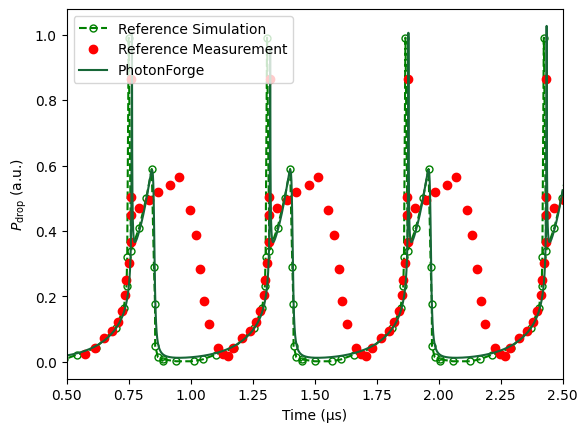

In [8]:
# 1. Reference data from the paper's simulation
paper_sim_data = np.array(
    [
        [0.45402014785524547, 0.007705825667357836],
        [0.5182756622016138, 0.0019292300361637534],
        [0.6054313155845404, 0.0019799019276654573],
        [0.6512671528797637, 0.007820504158651205],
        [0.7153982099487591, 0.022392673377877267],
        [0.807016545706046, 0.04279477706145724],
        [0.9075602462120539, 0.10389974432919321],
        [0.9484711312455326, 0.1649700413553754],
        [0.9618236191465076, 0.23183826954601568],
        [0.9652902308149105, 0.31904726176210186],
        [0.9725960010098827, 0.9905538348843084],
        [0.9841014717962031, 0.339409361320812],
        [1.0249590179965222, 0.4092005575686029],
        [1.061087187656683, 0.5022448181323589],
        [1.088076637235484, 0.589469811998393],
        [1.0990822164774325, 0.2900576059398128],
        [1.1043627609602413, 0.17668858300055863],
        [1.1051450638465832, 0.04878206108363193],
        [1.119119838134421, 0.013906465022171361],
        [1.1467137944890318, 0.002294601043307899],
    ]
)

# 2. Experimental measurement data
paper_exp_data = np.array(
    [
        [4.417166570064114, 0.0232657945174801],
        [4.458326369652338, 0.0436385618428223],
        [4.494845690755668, 0.07272956144811517],
        [4.526831211040428, 0.0930969948901412],
        [4.549589113188561, 0.12217999367045997],
        [4.567724316462854, 0.1570742583235262],
        [4.5812012616412, 0.20359372166374647],
        [4.585503927516082, 0.25010785112065],
        [4.59435817382059, 0.302438580333618],
        [4.603141301680885, 0.3663971751753971],
        [4.602643472571395, 0.4477922345770777],
        [4.602305659961384, 0.5030245963139322],
        [4.6046881278425165, 0.8634910977487467],
        [4.6346112132451, 0.4710666344263068],
        [4.675753233222271, 0.4943463681588515],
        [4.712308113547708, 0.5176234349497384],
        [4.762624412828346, 0.5409085025655993],
        [4.799179293153783, 0.5641855693564859],
        [4.841068056795191, 0.4653727139865105],
        [4.864483804552292, 0.3868979557003223],
        [4.883454649546087, 0.2851647992148541],
        [4.8978205752770965, 0.1863359421949303],
        [4.916595844549305, 0.1165794161886927],
        [4.95375523165022, 0.0410196251346822],
        [4.995181725404576, 0.0177878963519808],
    ]
)

# --- Plotting Parameters ---
period_us = 0.558  # Use the same period for both datasets
n_periods = 4  # Show a few periods for context
pf_y_scale = 1 / 0.0054  # Scale to convert sim units to a.u.

# Anchors to align the first peak of each tiled dataset
sim_anchor = 1.64
exp_anchor = -2.17

# --- Create the Combined Plot ---
fig, ax = plt.subplots()

# Plot Reference Data (tiled)
for k in range(n_periods):
    shift = sim_anchor - k * period_us
    label = "Reference Simulation" if k == 0 else "_nolegend_"
    ax.plot(
        paper_sim_data[:, 0] / 1.24 + shift,
        paper_sim_data[:, 1],
        "o--",
        color="green",
        label=label,
        markersize=5,
        mfc="none",
    )

# Plot Measurement Data (tiled)
for k in range(n_periods):
    shift = exp_anchor - k * period_us
    label = "Reference Measurement" if k == 0 else "_nolegend_"
    ax.plot(
        paper_exp_data[:, 0] + shift,
        paper_exp_data[:, 1],
        marker="o",
        color="red",
        label=label,
        linestyle="None",
    )

# Plot PhotonForge Data
ax.plot(t_eval * 1e6, P_drop * pf_y_scale, label="PhotonForge")

# Final touch
ax.set_xlim((0.5, 2.5))
ax.set_xlabel("Time (µs)")
ax.set_ylabel(r"$P_{\mathrm{drop}}$ (a.u.)")
ax.legend(loc="upper left")
plt.show()


The purpose of this notebook is **not** to exactly reproduce experimental traces, but to demonstrate how one can implement an **arbitrary nonlinear time-domain model** in PhotonForge and integrate it into larger circuit simulations.  

Here, we compare our PhotonForge simulation with the **reference simulation** reported in [1]. This keeps the story focused on validating the ODE implementation and showing how nonlinear dynamics such as free-carrier effects and thermal feedback can be modeled.  

The original paper [1] further refines these equations to achieve closer agreement with experimental measurements. Readers who are interested in matching experimental data are encouraged to refer to the paper for those extended models.  
